In [2]:
import json
from pathlib import Path
import pandas as pd
from tqdm import tqdm

In [3]:
ROOT = Path("/Users/zebbarry/Desktop/Stanford/AA272/GNSS Dataset (with Interference and Spoofing) Part III/1221")        # or Path("GNSS dataset") / "1221"
DAY  = 12                  # example
#HOUR = 14                  # example (if you have hour subfolders)

In [4]:
def load_rawx(day, hour=None):
    if hour is None:
        folder = ROOT / "Raw data" / f"{day}" / "RXM-RAWX"
    else:
        folder = ROOT / "Raw data" / f"{day}" / f"{hour}" / "RXM-RAWX"

    rows = []
    for path in sorted(folder.glob("*.json")):
        with open(path, "r", encoding="utf-8") as f:
            d = json.load(f)

        t = d["start_time"]
        numMeas = d["numMeas"]

        for i in range(1, numMeas + 1):
            # match their naming style gnssId_01 ... gnssId_10 ...
            key = f"{i}" if i >= 10 else f"0{i}"

            rows.append({
                "time": t,
                "gnssId": d[f"gnssId_{key}"],
                "svId":   d[f"svId_{key}"],
                "sigId":  d[f"sigId_{key}"],
                "pseudorange":  d.get(f"prMes_{key}", None),
                "doppler":      d.get(f"doMes_{key}", None),
                "carrier_phase": d.get(f"cpMes_{key}", None),
                "cn0":          d.get(f"cno_{key}", None),
                "pr_std":       d.get(f"prStd_{key}", None),
                "cp_std":       d.get(f"cpStd_{key}", None),
                "do_std":       d.get(f"doStd_{key}", None),
            })

    return pd.DataFrame(rows)

In [5]:
def load_nav_sat(day, hour=None):
    if hour is None:
        folder = ROOT / "Raw data" / f"{day}" / "NAV-SAT"
    else:
        folder = ROOT / "Raw data" / f"{day}" / f"{hour}" / "NAV-SAT"

    rows = []
    for path in sorted(folder.glob("*.json")):
        with open(path, "r", encoding="utf-8") as f:
            d = json.load(f)

        t = d["start_time"]
        numSvs = d["numSvs"]

        for i in range(1, numSvs + 1):
            key = f"{i}" if i >= 10 else f"0{i}"

            rows.append({
                "time": t,
                "gnssId":  d[f"gnssId_{key}"],
                "svId":    d[f"svId_{key}"],
                "svUsed":  d.get(f"svUsed_{key}", None),
                "cn0_sat": d.get(f"cno_{key}", None),
                "elev":    d.get(f"elev_{key}", None),
                "azim":    d.get(f"azim_{key}", None),
                "prRes":   d.get(f"prRes_{key}", None),
                "qualityInd": d.get(f"qualityInd_{key}", None),
                "health":  d.get(f"health_{key}", None),
            })

    return pd.DataFrame(rows)

In [6]:
def load_pvt_clock(day, hour=None):
    # PVT
    if hour is None:
        pvt_folder   = ROOT / "Raw data" / f"{day}" / "NAV-PVT"
        pose_folder  = ROOT / "Raw data" / f"{day}" / "NAV-POSECEF"
        clock_folder = ROOT / "Raw data" / f"{day}" / "NAV-CLOCK"
        dop_folder   = ROOT / "Raw data" / f"{day}" / "NAV-DOP"
    else:
        pvt_folder   = ROOT / "Raw data" / f"{day}" / f"{hour}" / "NAV-PVT"
        pose_folder  = ROOT / "Raw data" / f"{day}" / f"{hour}" / "NAV-POSECEF"
        clock_folder = ROOT / "Raw data" / f"{day}" / f"{hour}" / "NAV-CLOCK"
        dop_folder   = ROOT / "Raw data" / f"{day}" / f"{hour}" / "NAV-DOP"

    # PVT (position, velocity, etc.)
    pvt_rows = []
    for path in sorted(pvt_folder.glob("*.json")):
        with open(path, "r", encoding="utf-8") as f:
            d = json.load(f)

        pvt_rows.append({
            "time": d["start_time"],
            "numSV": d["numSV"],
            "nano":  d["nano"],
            "lon":   d["lon"],
            "lat":   d["lat"],
            "height": d["height"],
            "velN": d["velN"],
            "velE": d["velE"],
            "velD": d["velD"],
            "hMSL": d["hMSL"],
            "hAcc": d["hAcc"],
            "vAcc": d["vAcc"],
            "sAcc": d["sAcc"],
            "gSpeed": d["gSpeed"],
            "headMot": d["headMot"],
            "headAcc": d["headAcc"],
        })

    pvt_df = pd.DataFrame(pvt_rows)

    # ECEF
    pose_rows = []
    for path in sorted(pose_folder.glob("*.json")):
        with open(path, "r", encoding="utf-8") as f:
            d = json.load(f)
        pose_rows.append({
            "time": d["start_time"],
            "ecefX": d["ecefX"],
            "ecefY": d["ecefY"],
            "ecefZ": d["ecefZ"],
        })
    pose_df = pd.DataFrame(pose_rows)

    # Clock
    clk_rows = []
    for path in sorted(clock_folder.glob("*.json")):
        with open(path, "r", encoding="utf-8") as f:
            d = json.load(f)
        clk_rows.append({
            "time": d["start_time"],
            "clkB": d["clkB"],
            "clkD": d["clkD"],
            "tAcc": d["tAcc"],
            "fAcc": d["fAcc"],
        })
    clk_df = pd.DataFrame(clk_rows)

    # DOP
    dop_rows = []
    for path in sorted(dop_folder.glob("*.json")):
        with open(path, "r", encoding="utf-8") as f:
            d = json.load(f)
        dop_rows.append({
            "time": d["start_time"],
            "gDOP": d["gDOP"],
            "pDOP": d["pDOP"],
            "tDOP": d["tDOP"],
            "vDOP": d["vDOP"],
            "hDOP": d["hDOP"],
            "nDOP": d["nDOP"],
            "eDOP": d["eDOP"],
        })
    dop_df = pd.DataFrame(dop_rows)

    # merge on time
    df = pvt_df.merge(pose_df, on="time", how="inner") \
               .merge(clk_df, on="time", how="inner") \
               .merge(dop_df, on="time", how="inner")
    return df

In [7]:
from datetime import datetime
import numpy as np
from tqdm import tqdm

from spoofing_detection.csv_to_navdata import CSVToNavData


hours = list(range(12, 16))   # [12, 13, ..., 23]

all_full: list[pd.DataFrame] = []

cols = [
    "time", "gnssId", "svId", "sigId",
    "pseudorange", "doppler", "cn0",
    "elev", "azim", "prRes",
    "clkB", "clkD",
    "lon", "lat", "height",
    "ecefX", "ecefY", "ecefZ",
    "carrier_phase",
]

for hr in tqdm(hours):
    if hr in (18, 19):
        continue
    pickle_name = f"../data/yunnan/gnss_observables_{hr}.pickle"
    if Path(pickle_name).exists():
        print(f"Hour {hr} already processed, loading from {pickle_name}")
        full_df = pd.read_pickle(pickle_name)
    else:
        try:
            rawx_df   = load_rawx(hr)
            sat_df    = load_nav_sat(hr)
            pvtclk_df = load_pvt_clock(hr)

            # add observables
            obs_df = rawx_df.merge(
                sat_df,
                on=["time", "gnssId", "svId"],
                how="left",
                suffixes=("", "_sat"),
            )

            # add receiver info
            full_df = obs_df.merge(
                pvtclk_df,
                on="time",
                how="left",
            )

            full_df = full_df[cols]
            full_df.to_pickle(pickle_name)
        except KeyboardInterrupt:
            print("Interrupted by user at hour", hr)
            break
    all_full.append(full_df)

full_all = pd.concat(all_full, ignore_index=True)

# Remove the jamming data we dont want that as skews results
jamming_start_time = datetime(2023, 12, 21, 16, 50, 0)
jamming_end_time = datetime(2023, 12, 21, 17, 25, 0)
time = pd.to_datetime(full_all['time'], format="%Y-%m-%d %H:%M:%S")
mask = np.logical_or(time < jamming_start_time, time > jamming_end_time)

full_all[mask].to_csv("../data/yunnan/gnss_observables_all_hours.csv", index=False)

100%|██████████| 4/4 [00:00<00:00, 23.53it/s]


Hour 12 already processed, loading from ../data/yunnan/gnss_observables_12.pickle
Hour 13 already processed, loading from ../data/yunnan/gnss_observables_13.pickle
Hour 14 already processed, loading from ../data/yunnan/gnss_observables_14.pickle
Hour 15 already processed, loading from ../data/yunnan/gnss_observables_15.pickle


In [8]:
df = pd.read_pickle("../data/yunnan/gnss_observables_12.pickle")
# df = full_all[mask]
df.columns


Index(['time', 'gnssId', 'svId', 'sigId', 'pseudorange', 'doppler', 'cn0',
       'elev', 'azim', 'prRes', 'clkB', 'clkD', 'lon', 'lat', 'height',
       'ecefX', 'ecefY', 'ecefZ', 'carrier_phase', 'hour_block'],
      dtype='object')

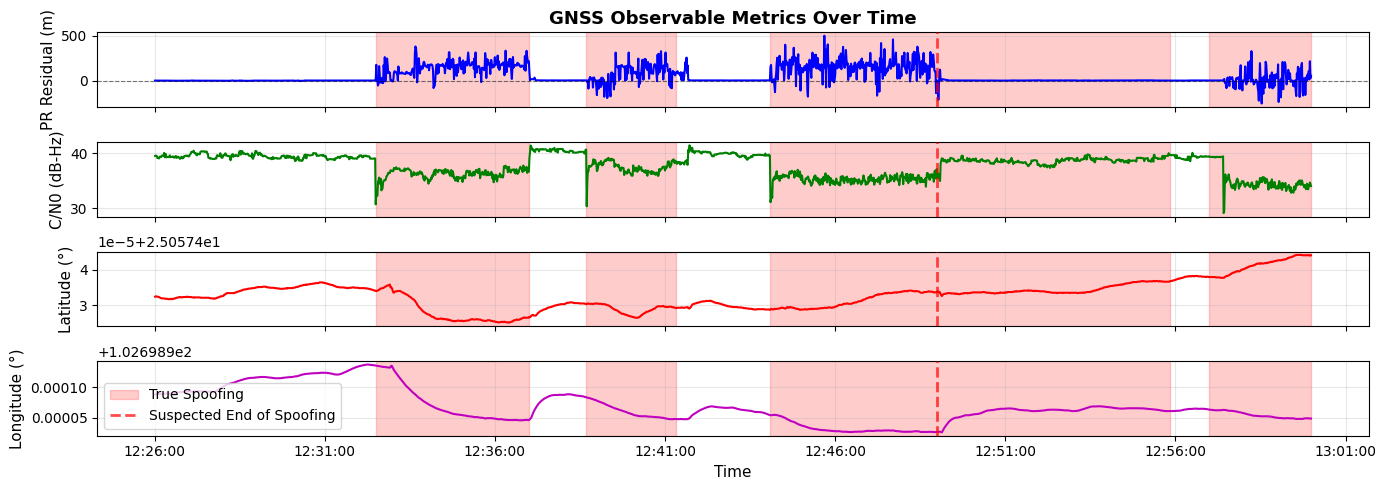

In [9]:
from matplotlib import dates, pyplot as plt

from spoofing_detection.plotting import add_ground_truth_shading, is_spoofing_active


if not pd.api.types.is_datetime64_any_dtype(df['time']):
    df["time"] = pd.to_datetime(df["time"], format="%Y-%m-%d %H:%M:%S")

# Remove the jamming data we dont want that as skews results
start_time = datetime(2023, 12, 21, 12, 26, 0)
end_time = datetime(2023, 12, 21, 17, 25, 0)
mask = np.logical_and(df["time"] > start_time, df["time"] < end_time)

grouped = df[mask].groupby('time').agg({
    'prRes': 'mean',
    'cn0': 'mean',
    'lat': 'mean',
    'lon': 'mean',
    'carrier_phase': 'mean'
}).reset_index()

fig, axes = plt.subplots(4, 1, figsize=(14, 5), sharex=True)

axes[0].plot(grouped['time'], grouped['prRes'], 'b-', linewidth=1.5)
axes[0].set_ylabel('PR Residual (m)', fontsize=11)
axes[0].set_title('GNSS Observable Metrics Over Time', fontsize=13, fontweight='bold')
axes[0].axhline(y=0, color='k', linestyle='--', linewidth=0.8, alpha=0.5)

axes[1].plot(grouped['time'], grouped['cn0'], 'g-', linewidth=1.5)
axes[1].set_ylabel('C/N0 (dB-Hz)', fontsize=11)

axes[2].plot(grouped['time'], grouped['lat'], 'r-', linewidth=1.5)
axes[2].set_ylabel('Latitude (°)', fontsize=11)

axes[3].plot(grouped['time'], grouped['lon'], 'm-', linewidth=1.5)
axes[3].set_ylabel('Longitude (°)', fontsize=11)

time_span = (grouped['time'].max() - grouped['time'].min()).total_seconds()

date_format = dates.DateFormatter('%H:%M:%S')
axes[3].xaxis.set_major_locator(dates.MinuteLocator(interval=5))
axes[3].xaxis.set_major_formatter(date_format)
axes[3].set_xlabel('Time', fontsize=11)


gps_millis = ((grouped['time'] - CSVToNavData.GPS_EPOCH).dt.total_seconds() * 1000.0).values
gt_df = pd.read_csv(
    "/Users/zebbarry/Desktop/Stanford/AA272/spoof-busters/yunnan_spoofing_times.csv",
    parse_dates=['start', 'stop'],
    date_format="%Y-%m-%d %H:%M:%S",
)

gt_df['start_gps_millis'] = gt_df['start'].apply(
    lambda x: (x - CSVToNavData.GPS_EPOCH).total_seconds() * 1000.0
)
gt_df['stop_gps_millis'] = gt_df['stop'].apply(
    lambda x: (x - CSVToNavData.GPS_EPOCH).total_seconds() * 1000.0
)
gt_active = is_spoofing_active(gps_millis, gt_df)

highlight_datetime = datetime(2023, 12, 21, 12, 49, 0)
for ax in axes:
    add_ground_truth_shading(ax, grouped["time"], gt_active)
    ax.axvline(x=highlight_datetime, color='red', linestyle='--', 
                      linewidth=2, alpha=0.7, zorder=10, label="Suspected End of Spoofing")
    ax.grid(True, alpha=0.3)

axes[-1].legend()

plt.tight_layout()

/var/folders/yc/ccq736xx7v1gjxcsd4_kmm9r0000gn/T/ipykernel_2082/1659694280.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[df["gnssId"] == 0][df["svId"] == 9][df["sigId"] == 3]
/var/folders/yc/ccq736xx7v1gjxcsd4_kmm9r0000gn/T/ipykernel_2082/1659694280.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[df["gnssId"] == 0][df["svId"] == 9][df["sigId"] == 3]


<Axes: >

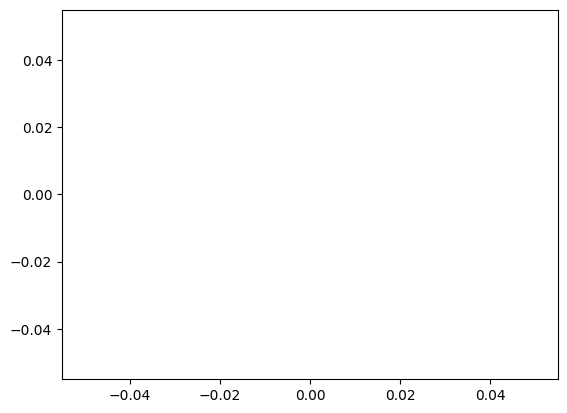

In [10]:
df = df[df["gnssId"] == 0][df["svId"] == 9][df["sigId"] == 3]
df["time"] = pd.to_datetime(df["time"], format="%Y-%m-%d %H:%M:%S")
df["pr_vel_m_s"] = df["pseudorange"].diff() / pd.to_numeric(df["time"].diff())
df["doppler_vel_m_s"] = -df["doppler"] / 1227.6e6
# df["doppler_vel_m_s_zeroed"] = df["doppler_vel_m_s"] + (df["pr_vel_m_s"].iloc[-1] - df["doppler_vel_m_s"].iloc[-1])
# df["vel_diff"] = (df["doppler_vel_m_s"] - df["pr_vel_m_s"]) * 1e6
# df["vel_diff"].plot()

df["pr_vel_m_s"].plot()
df["doppler_vel_m_s"].plot()


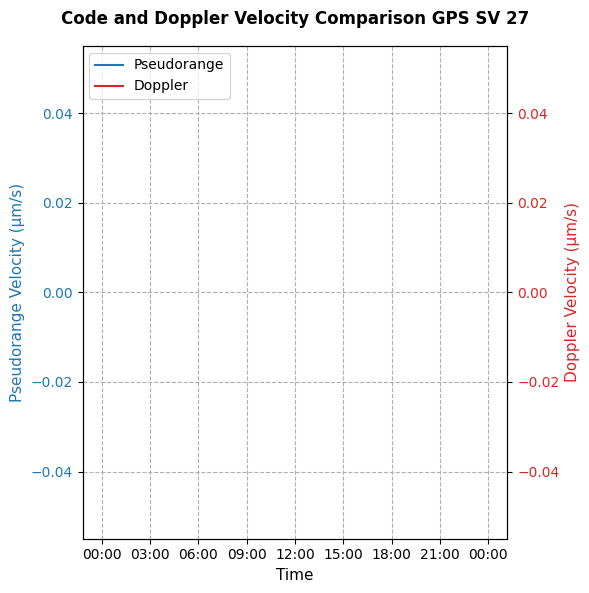

In [12]:
from matplotlib import pyplot as plt
from matplotlib.dates import DateFormatter


fig, ax1 = plt.subplots(figsize=(6, 6))
date_formatter = DateFormatter("%H:%M")

color1 = 'tab:blue'
ax1.set_xlabel('Time', fontsize=11)
ax1.set_ylabel('Pseudorange Velocity (µm/s)', color=color1, fontsize=11)
ax1.plot(df['time'], df['pr_vel_m_s'] * 1e6, color=color1, linestyle="-", marker="", label='Pseudorange')
ax1.tick_params(axis='y', labelcolor=color1)
ax1.grid(True, linestyle='--')

ax2 = ax1.twinx()  

color2 = 'tab:red'
ax2.set_ylabel('Doppler Velocity (µm/s)', color=color2, fontsize=11)
ax2.plot(df['time'], df['doppler_vel_m_s'] * 1e6, color=color2, linestyle='-', marker="", label='Doppler')
ax2.tick_params(axis='y', labelcolor=color2)

fig.suptitle('Code and Doppler Velocity Comparison GPS SV 27', fontsize=12, fontweight="bold")
lines = ax1.get_lines() + ax2.get_lines()
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper left')
ax1.xaxis.set_major_formatter(date_formatter)
ax2.xaxis.set_major_formatter(date_formatter)

fig.tight_layout()

\begin{equation}
v_{\text{code}} = \frac{\Delta \rho}{\Delta t} \quad \text{(pseudorange rate)}
\end{equation}

\begin{equation}
v_{\text{Doppler}} = -f_D \cdot \lambda \quad \text{(Doppler-based range rate)}
\end{equation}

\begin{equation}
\text{Ideally: } v_{\text{code}} = v_{\text{Doppler}}
\end{equation}